In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_groq import ChatGroq

In [3]:
llm=ChatGroq(model_name="deepseek-r1-distill-llama-70b")

In [4]:
llm.invoke("What is the capital of France?")

AIMessage(content='<think>\n\n</think>\n\nThe capital of France is Paris.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 10, 'total_tokens': 22, 'completion_time': 0.05516408, 'prompt_time': 0.000449175, 'queue_time': 0.20286869800000001, 'total_time': 0.055613255}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--a4dfe1f1-14f8-4b5b-9f43-8f49c95a431c-0', usage_metadata={'input_tokens': 10, 'output_tokens': 12, 'total_tokens': 22})

In [5]:
from langchain_core.tools import tool

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [7]:
@tool
def multiply(x: int, y: int) -> int:
    """Multiplies two numbers."""
    return x * y

In [9]:
multiply({"x":2, "y":3})

6

In [10]:
@tool
def search(query: str):
    """search the web for a query and return the results"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return f"Result for {query} is: \n{result}"

In [11]:
print(search.invoke({"query":"What is the capital of France?"}))

C:\Users\MILAN\AppData\Local\Temp\ipykernel_29508\2168271535.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


Result for What is the capital of France? is: 
[{'title': 'List of capitals of France - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/List_of_capitals_of_France', 'content': 'This is a chronological list of capitals of France. The capital of France has been Paris since its liberation in 1944.\n\n## Chronology\n\n[edit] [...] - Tours (10–13 June 1940), the city served as the temporary capital of France during World War II after the government fled Paris due to the German advance.\n- Bordeaux (June 1940), the government was relocated from Paris to Tours then Bordeaux very briefly during World War II, when it became apparent that Paris would soon fall into German hands. [...] - Paris (1789–1871), on 5 and 6 October 1789, a throng from Paris invaded the castle and forced the royal family to move back to Paris. The National Constituent Assembly "National Constituent Assembly (France)") followed the King to Paris soon afterward; Versailles lost its role of capital city.', 'score': 0.8993

In [12]:
tools = [multiply, search]

In [13]:
tools

[StructuredTool(name='multiply', description='Multiplies two numbers.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000020166C42B60>),
 StructuredTool(name='search', description='search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000201671A14E0>)]

In [14]:
llm_with_tool=llm.bind_tools(tools)

In [15]:
result = llm_with_tool.invoke("What is the current GDP of India?")

In [18]:
result.content

"To find the current GDP of India, I'll perform a web search.\n\n"

In [17]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'current GDP of India'},
  'id': 'nptakmh0w',
  'type': 'tool_call'}]

In [22]:
result.tool_calls[0]["name"]

'search'

In [23]:
result.tool_calls[0]["args"]

{'query': 'current GDP of India'}

In [24]:
type(result.tool_calls[0]["args"])

dict

In [19]:
tool_mapping={tool.name:tool for tool in tools}

In [20]:
tool_mapping

{'multiply': StructuredTool(name='multiply', description='Multiplies two numbers.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000020166C42B60>),
 'search': StructuredTool(name='search', description='search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000201671A14E0>)}

In [21]:
tool_mapping["search"]

StructuredTool(name='search', description='search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000201671A14E0>)

In [ ]:
#manually 
# tool_mapping["search"].invoke({"query":"What is the capital of india?"})

In [25]:
tool_mapping[result.tool_calls[0]["name"]].invoke(result.tool_calls[0]["args"])

'Result for current GDP of India is: \n[{\'title\': \'India GDP - Worldometer\', \'url\': \'https://www.worldometers.info/gdp/india-gdp/\', \'content\': \'| Year | GDP Nominal (Current USD) | GDP Real (Inflation adj.) | GDP Change | GDP per capita | Pop. Change | Population |\\n| --- | --- | --- | --- | --- | --- | --- |\\n| 2023 | $3,567,550,000,000 | $3,215,970,000,000 | 8.15% | $2,236 | 0.89% | 1,438,069,596 |\\n| 2022 | $3,353,470,000,000 | $2,973,540,000,000 | 6.99% | $2,086 | 0.79% | 1,425,423,212 |\\n| 2021 | $3,167,270,000,000 | $2,779,350,000,000 | 9.69% | $1,965 | 0.83% | 1,414,203,896 | [...] | 2020 | $2,674,850,000,000 | $2,533,830,000,000 | −5.78% | $1,807 | 0.98% | 1,402,617,695 |\\n| 2019 | $2,835,610,000,000 | $2,689,210,000,000 | 3.87% | $1,936 | 1.05% | 1,389,030,312 |\\n| 2018 | $2,702,930,000,000 | $2,588,970,000,000 | 6.45% | $1,883 | 1.1% | 1,374,659,064 |\\n| 2017 | $2,651,470,000,000 | $2,432,020,000,000 | 6.8% | $1,789 | 1.17% | 1,359,657,400 |\\n| 2016 | $2,29

In [26]:
from typing import TypedDict, Sequence, Annotated

In [27]:
import operator

In [28]:
from langchain_core.messages import BaseMessage

In [29]:
class AgentState(TypedDict):
    """State for the agent."""
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [30]:
def invoke_model(state:AgentState):
    messages=state["messages"]
    question=messages[-1]
    response=llm_with_tools.invoke(question)
    return {"messages":[response]}

In [34]:
def router(state:AgentState):
    tool_calls=state["messages"][-1].tool_calls
    if len(tool_calls)>0:
        return "tool" #key name
    else:
        return "end" #key name

In [33]:
def invoke_tool(state:AgentState):
    tool_details=state["messages"][-1].tool_calls
    
    if tool_details is None:
        return Exception("No tool calls found in the last message.")
    
    print(f"Seleted tool: {tool_details[0]['name']}")
    
    if tool_details[0]["name"]=="search":
        response=input(prompt=f"[yes/no] do you want to continue with this expensive web search")
        if response.lower()=="no":
            print("web search discarded by the user. exiting gracefully")
            raise Exception("Web search discarded by the user.")
            
    
    response=tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])
    return {"messages":[response]}

### eariler we were using the tool node from list of tool
### but now we have create tool invoke(custom funtion)
### why we are doing it: as a user if we want to take a authority to which i need to give permission for execution

In [51]:
from langgraph.graph import StateGraph, START,END

In [52]:
graph=StateGraph(AgentState)

In [53]:
graph.add_node("ai_assistant", invoke_model)

In [54]:
graph.add_node("tool", invoke_tool)

In [55]:
graph.add_conditional_edges("ai_assistant",
                            router,
                            {
                                "tool":"tool", ##with the key tool which value is associated <tool>
                                "end":END
                            }
                            )

In [56]:
graph.add_edge("tool", END)

In [57]:
graph.set_entry_point("ai_assistant")

In [58]:
app=graph.compile()

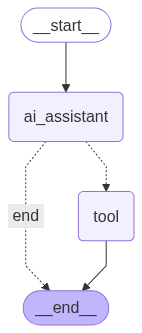

In [59]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))